In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
#### Authenticating but this should be removed ####
!az login

A web browser has been opened at https://login.microsoftonline.com/organizations/oauth2/v2.0/authorize. Please continue the login in the web browser. If no web browser is available or if the web browser fails to open, use device code flow with `az login --use-device-code`.
The following tenants require Multi-Factor Authentication (MFA). Use 'az login --tenant TENANT_ID' to explicitly login to a tenant.
3fa8b7cf-7031-4cc8-8ba9-fca81d0a1eec 'SeekOps Operations'
[
  {
    "cloudName": "AzureCloud",
    "homeTenantId": "dd38e5a0-643a-4ddf-b6cc-fdde7fa8bfcf",
    "id": "8c84123f-2022-4815-9864-dc46351b2261",
    "isDefault": true,
    "managedByTenants": [],
    "name": "test-subscription",
    "state": "Enabled",
    "tenantId": "dd38e5a0-643a-4ddf-b6cc-fdde7fa8bfcf",
    "user": {
      "name": "kdawson@seekops.com",
      "type": "user"
    }
  }
]


# Technical Interview
### Data Engineer (with specialty in geospatial)
A data engineer is an IT worker whose primary job is to prepare data for analytical or operational uses. These software engineers are typically responsible for building data pipelines to bring together information from different source systems.

### Interview Core Competencies
1. Database Access (Postgres SQL)
2. Statistical Data Summary (Group by with Plot)  
3. Geospatial Data Wrangling (convert to UTM)  
4. Data Creation  
_There will be active Troubleshooting along the way_

# Problem Statement
You are a data engineer. You are asked by the Data Science team to help retrieve a spatially referenced dataset of methane concentration and emission data collected by an unmanned aerial system (UAS). Additionally, the data scientists want to be sure that the data are over their area of interest (AOI) and are of high quality as they will be testing some of their Machine Learning algorithms on this case study.  

**Your task is to:  
(1) retrieve this dataset,  
(2) analyze the results with a statistical summary, and  
(3) present a _(very simple)_ spatial map showing the UAS flight paths colored by emissions data**

# 1. Database Access
Using the schema information and pseudo-code below, please write and execute a SQL query to retrieve spatially referenced concentration and base station data for **Survey ID 16022**

##### Database ER Diagram
![ER-Diagram](./diagrams/er_diagram_for_interviews.png)

#### **<span style="color:red">REDACT</span>**
Redact the part to add the folder to the system path. I want to see if they recognize the error
```python
import sys
sys.path.append('./helpers')
```

In [3]:
import sys  # redact
sys.path.append('./helpers')  # redact
''' Use our query package to read data '''
from queryControlled import queryKowalski as qKow

#### Pseudo-Code
```python
queryString = """
select <data> 
from datatable_1
left join datatable_1.primary_key
  on datatable2.key_name = datatable1.primary_key
where <some filter>
"""
```

In [4]:
# Redact the real query String!
# I want to see if they can implement the SQL geometry features to decode location to lat and long.
queryString="""
with meas as (
    select 
           am.survey_id,
           am.timestamp,
           ST_X(am.location) as longitude,
           ST_Y(am.location) as latitude,
           am.lidar_altitude as altitude,
           am.concentration*1e6 as concentration
    from api_measurement am
    where (am.survey_id=16022)
    )
 select 
   meas.*,
   ab.wind_u,
   ab.wind_v,
   ab.wind_w
 from api_basestationmesurement ab
 join meas
   on meas.survey_id=ab.survey_id
 where ab.timestamp=meas.timestamp
"""

In [5]:
# Retrieve the data for the queryString
dataFrame = qKow.get_data(queryString)

# 2. Summarize the Data

In this section, we want to see a boxplot of concentration data as a function of `altitude`

Text(0, 0.5, 'concentration [ppm]')

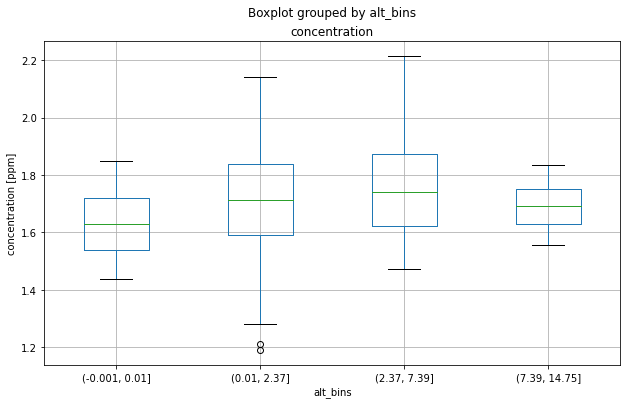

In [6]:
# I want to see here a simple boxplot. I am hoping the candidate identifies the need to bin altitudes
# into discreet levels
import pandas as pd
dataFrame['alt_bins']=pd.qcut(dataFrame['altitude'], q=4)
dataFrame[['concentration','alt_bins']].drop_duplicates().boxplot(column='concentration',by='alt_bins',figsize=(10,6)).set_ylabel('concentration [ppm]')

# 3. Geospatial Data Conversion
We frequently need to work with distance between points. One way to do this is to convert the coordinate system from degrees into meters. This survey took place in Southern California, in UTM zone 11 for NAD83 Datum. Please convert the coordinate system with this in mind.  
  
**If you need a hint, click below:**

In [7]:
from IPython.display import display
from ipywidgets import widgets
button = widgets.Button(description="Show Me a Hint")
display(button)

output  = widgets.Output()
@output.capture()
def on_button_clicked(b):
    if b.description=="Show Me a Hint":
        curr_crs = "epsg:4326"
        new_crs  = "+proj=utm +zone=11 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
        print("You'll need to convert from WGS84 to the Southern California CRS")
        print("Try going from %s to %s"%(curr_crs,new_crs))
        b.description="Show me Another Hint"
    else:
        print("Try this:\n")
        print("""
        from pyproj import Transformer 

        #transformer to convert from 4326 (WGS84 - World Geodetic System 1984, used in GPS) to (epsg 3310 NAD83) / California Albers
        curr_crs = "epsg:4326"
        new_crs  = "+proj=utm +zone=11 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"

        transformer = Transformer.from_crs(curr_crs,new_crs,always_xy=True)

        xx, yy = transformer.transform(dataFrame["longitude"].values, dataFrame["latitude"].values)

        dataFrame["long_utm"] = xx
        dataFrame["lat_utm"]  = yy
        """)
    return

button.on_click(on_button_clicked)
display(output)

Button(description='Show Me a Hint', style=ButtonStyle())

Output()

In [8]:
from pyproj import Transformer 

#transformer to convert from 4326 (WGS84 - World Geodetic System 1984, used in GPS) to (epsg 3310 NAD83) / California Albers
curr_crs = "epsg:4326"
new_crs  = "+proj=utm +zone=11 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"

transformer = Transformer.from_crs(curr_crs,new_crs,always_xy=True)

xx, yy = transformer.transform(dataFrame["longitude"].values, dataFrame["latitude"].values)

dataFrame["long_utm"] = xx
dataFrame["lat_utm"]  = yy

* Transform CRS at [epsg.io](https://epsg.io/) 
* Pseudo-Code Help:

```python
from pyproj import Transformer 

# Set CRS transforms
curr_crs = "epsg:4326"
new_crs  = "find the UTM for california NAD83"

transformer = Transformer.from_crs(<curr_crs>,<convert_to_crs>,always_xy=True)

xx, yy = transformer.transform(<longitudes>,<latitudes>)

# TODO: Save the data back to the original dataFrame
```

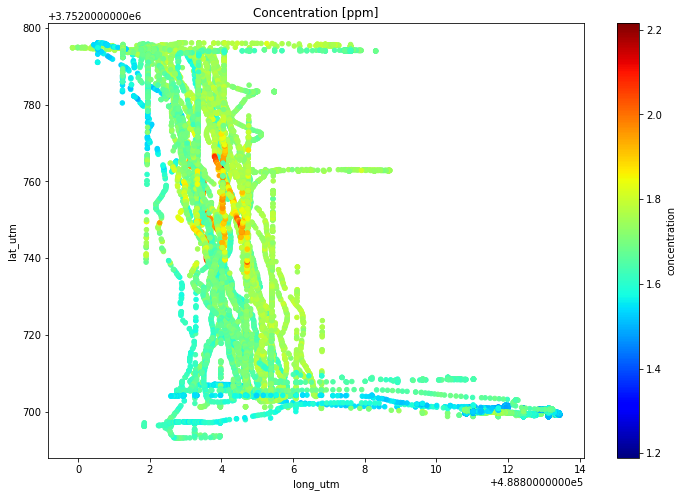

In [9]:
# Print the Figure
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
ax = plt.gca()
dataFrame.plot(x='long_utm',y='lat_utm',c='concentration',colormap='jet',kind='scatter',ax=ax).set_title('Concentration [ppm]');
plt.show()

# 4. Data Creation
We would like you to create a new dataset. In this dataset, we want to see wind speeds, wind directions, and concentrations normal to the wind flow. You can use the provided functions to calculate some of these. Click the buttons to show any hints

In [50]:
# Helpful Functions
def calculate_winds(**kwargs):
    from metpy.calc import wind_direction, wind_speed
    from metpy.units import masked_array
    from numpy import sqrt, log
    u       = kwargs['u_wind_2m'].values**2
    v       = kwargs['v_wind_2m'].values**2
    w       = kwargs['w_wind_2m'].values**2
    z       = kwargs['altitude'].values
    windspd = sqrt(u+v+w)
    z0 = 0.22
    
    # Set any z<z0 to the surface roughness height
    z[z<z0]=z0
    
    uc = masked_array(u, data_units="m/s")
    vc = masked_array(v, data_units="m/s")
    
    # windspd   = wind_speed(uc,vc)
    
    speed     = windspd*(log(z/z0)/log(2./z0))
    direction = wind_direction(uc,vc)
    
    return speed, direction

In [51]:
# Add wind speeds at lidar altitude and wind direction to dataframe
# Use the above function to help
dataFrame['windspeed'], dataFrame['winddirection'] = calculate_winds(u_wind_2m=dataFrame['wind_u'],
                                                                     v_wind_2m=dataFrame['wind_v'],
                                                                     w_wind_2m=dataFrame['wind_w'],
                                                                     altitude=dataFrame['altitude'])

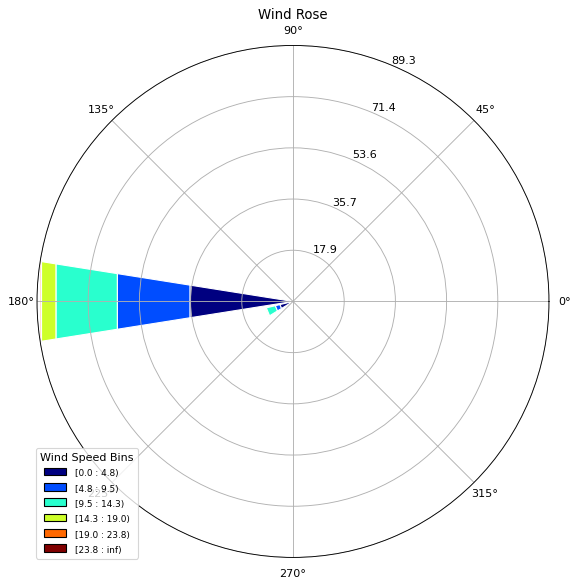

In [58]:
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Create wind speed and direction variables

ax = WindroseAxes.from_ax()
ax.set_title("Wind Rose")
ax.bar(dataFrame['winddirection'], dataFrame['windspeed'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend().set_title('Wind Speed Bins')